In [2]:
# Modules import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn import metrics

# Settings
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
sns.set(style="white")

In [149]:
# Import data
sales_train        = pd.read_csv('./readonly/sales_train.csv')
test               = pd.read_csv('./readonly/test.csv')
items              = pd.read_csv('./readonly/items.csv').set_index('item_id')
item_categories    = pd.read_csv('./readonly/item_categories.csv').set_index('item_category_id')
shops              = pd.read_csv('./readonly/shops.csv')

Lets consider what is hapenning with the value, which forms our target value. First idea is to watch a destribution plot and understand what happens with outliers.

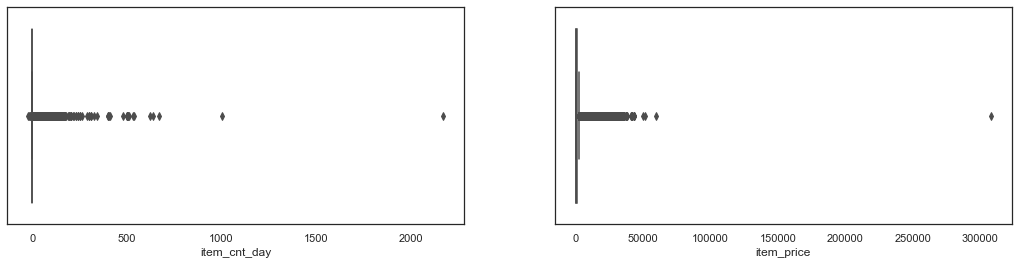

In [4]:
fig, ax = plt.subplots(1, 2, figsize = (18, 4))
sns.boxplot(sales_train['item_cnt_day'], ax = ax[0])
sns.boxplot(sales_train['item_price'], ax = ax[1])
plt.show()

According to the destribution there are sertain outliers in both cases. Let's dig into them and try to find any trends

In [92]:
# Let "counts" be an table in which every unique value of "item_cnt_day" column has a number of it's inclusions in data.
# Then let's take the i-th maximum nI (number of inclusions) and separate values of "count" table by this threshold.
# "proper_sales" dataframe will only include rows with "item_cnt_day" values, which nI is not less then threshold
i = 8

counts = sales_train['item_cnt_day'].value_counts()
unique_counts_values = counts.sort_values().unique()
threshold = counts[unique_counts_values[min(i, unique_counts_values.shape[0] - 1)]]

proper_values = counts[counts >= threshold].index
proper_sales = sales_train[sales_train['item_cnt_day'].isin(proper_values)]

improper_sales = sales_train.drop(proper_sales.index)

assert proper_sales.shape[0] + improper_sales.shape[0] == sales_train.shape[0], "Wrong sizes"

In [185]:
topn = 10
print('From top', topn, 'items by inclusions in \"improper\" items meet in \"test\" part of data:')
for i in improper_sales['item_id'].value_counts().sort_values(ascending=False).index[:topn]:
    if i in test['item_id'].unique():
        print(i, ' (', improper_sales['item_id'].value_counts().sort_values(ascending=False)[i], ' inclusions) - ',
              item_categories.loc[items.loc[i]['item_category_id']]['item_category_name'], ' - ',
              items.loc[i]['item_name'],
              sep='')

From top 10 items by inclusions in "improper" items meet in "test" part of data:
20949 (4998 inclusions) - Подарки - Сумки, Альбомы, Коврики д/мыши - Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
2808 (282 inclusions) - Игры PC - Стандартные издания - Diablo III [PC, Jewel, русская версия]
3732 (198 inclusions) - Игры - PS3 - Grand Theft Auto V [PS3, русские субтитры]
3731 (159 inclusions) - Игры PC - Стандартные издания - Grand Theft Auto V [PC, русские субтитры]
11370 (157 inclusions) - Доставка товара - Доставка (по Москве)
3734 (133 inclusions) - Игры - XBOX 360 - Grand Theft Auto V [Xbox 360, русские субтитры]
6675 (118 inclusions) - Игровые консоли - PS4 - Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1108A/B01)
11373 (106 inclusions) - Доставка товара - Доставка до пункта выдачи (Boxberry)
3331 (103 inclusions) - Игры PC - Стандартные издания - FIFA 14 [PC, русская версия]


Games are popular, so are the 1C special gifts (item 20949). Let's separate these categories from the rest of data and see, what can we get from it

In [80]:
# Just useful function to see if some value has changes with respect to group of other columns
# Reminder: this function is a bt heavy
def has_changes_column(data, group_columns, check_column):
    group_data = data.groupby(group_columns)[[check_column]].nunique().reset_index()
    group_data = group_data[group_data[check_column] != 1]
    group_data['has_changes'] = True
    group_data = group_data.loc[:, group_columns + ['has_changes']]
    return pd.merge(data, group_data, on=group_columns, how='left')['has_changes'].fillna(False)

In [84]:
has_changes_column(sales_train, ['date_block_num', 'shop_id', 'item_id'], 'item_price').value_counts()

False    2511462
True      424387
Name: has_changes, dtype: int64

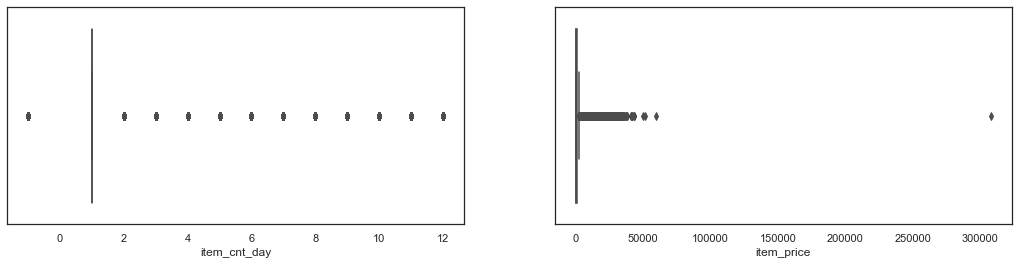

In [98]:
fig, ax = plt.subplots(1, 2, figsize = (18, 4))
sns.boxplot(proper_sales['item_cnt_day'], ax = ax[0])
sns.boxplot(proper_sales['item_price'], ax = ax[1])
plt.show()

It looks like the "1" value of "item_cnt_day" still dominates dataset, but is it real truth? What about 0?

In [ ]:
sales_train

In [ ]:
proper_sales = sales_train[sales_train['item_cnt_day'] <= ]

In [47]:
sales_train['item_cnt_day'].value_counts().sort_index()

-22.0            1
-16.0            1
-9.0             1
-6.0             2
-5.0             4
-4.0             3
-3.0            14
-2.0            78
-1.0          7252
 1.0       2629372
 2.0        194201
 3.0         47350
 4.0         19685
 5.0         10474
 6.0          6338
 7.0          4057
 8.0          2903
 9.0          2177
 10.0         1820
 11.0         1263
 12.0         1083
 13.0          918
 14.0          716
 15.0          638
 16.0          544
 17.0          438
 18.0          391
 19.0          347
 20.0          364
 21.0          290
 22.0          242
 23.0          198
 24.0          204
 25.0          180
 26.0          176
 27.0          130
 28.0          131
 29.0          102
 30.0          147
 31.0          123
 32.0          106
 33.0           82
 34.0           81
 35.0           69
 36.0           62
 37.0           61
 38.0           54
 39.0           52
 40.0           58
 41.0           58
 42.0           36
 43.0           34
 44.0       

In [5]:
hist, bin_edges = np.histogram(sales_train['item_cnt_day'])

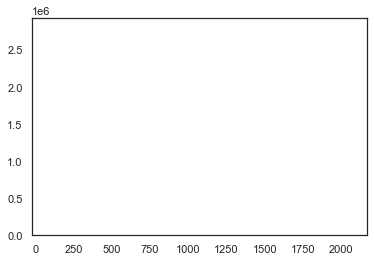

In [6]:
plt.bar(bin_edges[:-1], hist, width = 0.5, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), max(bin_edges))
plt.ylim(min(hist), max(hist))
plt.show()

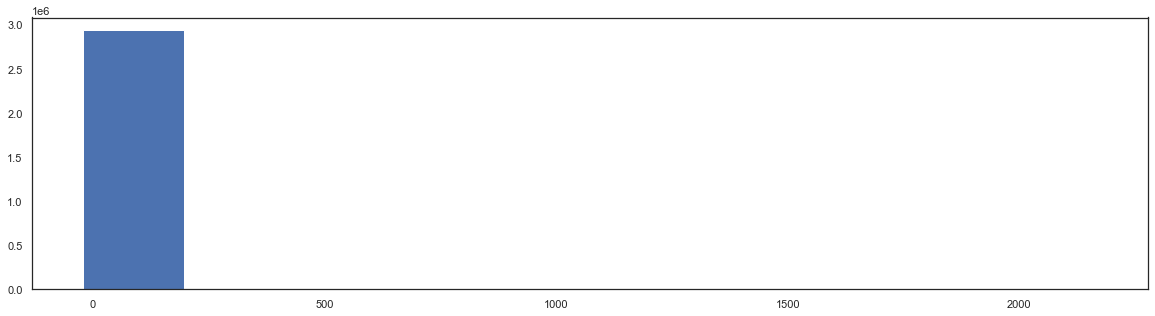

In [40]:
fig = plt.figure(figsize=(20, 5))
plt.hist(sales_train['item_cnt_day'])
plt.show()

In [4]:
# Parameters
items_sample_size = 50

# Include items and shops only from test
test_shops = test['shop_id'].unique()
test_items = test['item_id'].unique()

data = sales_train[
    sales_train['shop_id'].isin(test_shops) & 
    sales_train['item_id'].isin(test_items)].copy()

# Collect item prices (taking into account that prices should not differ much from shop to shop)
prices = sales_train.groupby(['item_id'])[['item_price']].mean()
data.drop('item_price', axis = 1, inplace = True)

# Drop column "date", which is not going to be used
data.drop('date', axis = 1, inplace = True)

# Get rid of mistakes in selection
data = data[data['item_cnt_day'] >= 0]

# If an item is not sold, our model should predict this fact
sp = []
for item in np.random.choice(test_items, items_sample_size, replace=False):
    for date_block in range(34):
        for shop in test_shops:
            sp.append([date_block, shop, item, 0])
zero_sales = pd.DataFrame(sp, columns = data.columns)
data = pd.concat([data, zero_sales])

# Making "target" values
data = data.groupby(["date_block_num", "shop_id", "item_id"])['item_cnt_day'].sum().reset_index()
data.rename(columns = {'item_cnt_day' : 'target'}, inplace=True)
data.loc[:, ('target')] = data['target'].astype('int32')

# Add categories' info
data = data.join(items.set_index('item_id')['item_category_id'], on='item_id')
data = data.join(prices, on=['item_id'])

# Change test to a format of "data" variable
build_test = test.join(items.set_index('item_id')['item_category_id'], on='item_id')
build_test = build_test.join(prices, on='item_id')
build_test.drop('ID', axis=1, inplace=True)

# Add "date_block_num" information
build_test['date_block_num'] = 34
build_test = build_test.reindex(columns=["date_block_num"] + list(build_test.columns)[:-1])

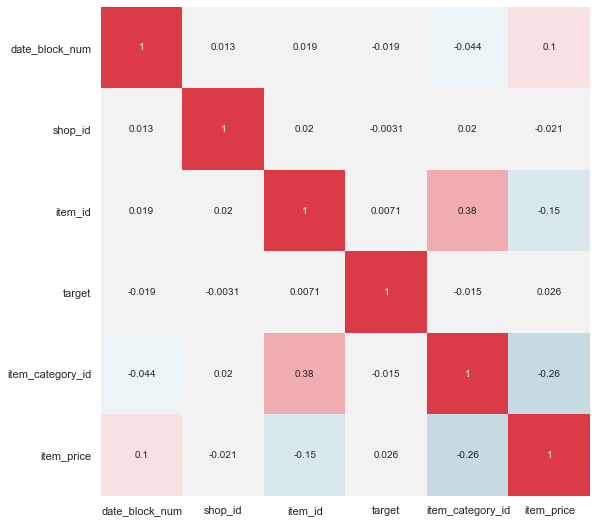

In [8]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, center = 0.,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            annot=True, cbar=False, square=True)

plt.yticks(rotation = 0)
plt.xticks(rotation = 0)
    
plt.show()

Let's conider the following format of data (conditions for the work of the code below): \
**Columns** : shop_id - item_id - item_category_id - item_price \
shop_id, item_id, item_category_id can't have NaNs \
item_price can have NaNs

In [19]:
# This function makes features which depend on a part of known dataset, such as mean values
# Also it doesn't matter if "test_input" has "target" column (for validation) or not (for the real test)
def preparation(data_input, test_input, mean_encoding, indexes_union_for_dummies):  
    data_train = data_input.copy()
    data_train.loc[:, 'item_price'].fillna(data_train['item_price'].mean(), inplace=True)

    data_test = test_input.copy()
    data_test.loc[:, 'item_price'].fillna(data_train['item_price'].mean(), inplace=True)
    
    # Mean encoding
    for column in mean_encoding:
        collect_means = data_train.groupby(column)[['target']].mean()
        collect_means.rename(columns = {'target' : 'mean_' + column}, inplace=True)

        data_train = data_train.join(collect_means, on=column)
        data_test = data_test.join(collect_means, on=column)
        data_test = data_test.fillna(method='ffill', axis=1)
       
    # One Hot encoding
    for column in list(indexes_union_for_dummies.keys()):
        ids_union = indexes_union_for_dummies[column]
        data_train.loc[:, column] = data_train[column].astype(pd.CategoricalDtype(categories=ids_union))
        data_test.loc[:, column] = data_test[column].astype(pd.CategoricalDtype(categories=ids_union))

        data_train = data_train.join(pd.get_dummies(data_train[column], prefix=column))
        data_test = data_test.join(pd.get_dummies(data_test[column], prefix=column))

        data_train.drop(column, axis=1, inplace=True)
        data_test.drop(column, axis=1, inplace=True)
        
    return data_train, data_test

#### Approach 0: Linear Regression

In [56]:
kf5 = KFold(n_splits = 5, shuffle=True)
indexes_union_for_dummies = dict()
mean_encoding =  []

for train_index, test_index in kf5.split(data):
    data_train, data_test = preparation(data.loc[train_index], data.loc[test_index], mean_encoding, indexes_union_for_dummies)
    
    X_train, X_test = data_train.drop('target', axis = 1), data_test.drop('target', axis = 1)
    y_train, y_test = data_train['target'].astype('float32'), data_test['target'].astype('float32')
    
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    print(metrics.mean_squared_error(y_test, lr.predict(X_test)))

104.9424183467713
109.95931521177557
142.80673025987474
113.93789702529644
104.41515470788808


#### Approach 1 : Mean encoding, Linear Regression

In [57]:
kf5 = KFold(n_splits = 5, shuffle=True)
indexes_union_for_dummies = dict()
mean_encoding =  ['shop_id', 'item_id', 'item_category_id']

for train_index, test_index in kf5.split(data):
    data_train, data_test = preparation(data.loc[train_index], data.loc[test_index], mean_encoding, indexes_union_for_dummies)
    
    X_train, X_test = data_train.drop('target', axis = 1), data_test.drop('target', axis = 1)
    y_train, y_test = data_train['target'].astype('float32'), data_test['target'].astype('float32')
    
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    print(metrics.mean_squared_error(y_test, lr.predict(X_test)))

75.9559944797769
79.74611194506095
60.093020590337574
103.83677194208866
59.1070037994563


#### Approach 2 : Mean encoding, One Hot encoding, Linear Regression

In [20]:
kf5 = KFold(n_splits = 5, shuffle=True)
indexes_union_for_dummies = dict()
mean_encoding =  ['shop_id', 'item_id', 'item_category_id']
for column in ['shop_id', 'item_category_id']:
    indexes_union_for_dummies[column] = list(set(build_test[column].unique().tolist()).union(set(data[column].unique().tolist())))

for train_index, test_index in kf5.split(data):
    data_train, data_test = preparation(data.loc[train_index], data.loc[test_index], mean_encoding, indexes_union_for_dummies)
    
    X_train, X_test = data_train.drop('target', axis = 1), data_test.drop('target', axis = 1)
    y_train, y_test = data_train['target'].astype('float32'), data_test['target'].astype('float32')
    
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    print(metrics.mean_squared_error(y_test, lr.predict(X_test)))

97.12592194538212
50.254617465669334
67.21406253718759
85.40748603954867
77.5712757397218


So I have chosen approach N

In [54]:
mean_encoding =  ['shop_id', 'item_id', 'item_category_id']
for column in ['shop_id', 'item_category_id']:
    indexes_union_for_dummies[column] = list(set(build_test[column].unique().tolist()).union(set(data[column].unique().tolist())))
    
data_train, data_test = preparation(data, build_test, mean_encoding, indexes_union_for_dummies)

lr = linear_model.LinearRegression()
lr.fit(data_train.drop('target', axis = 1), data_train['target'].astype('float32'))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
submission = pd.DataFrame(lr.predict(data_test))

submission.index.name = 'ID'
submission.columns = ['item_cnt_month']

submission.to_csv('./results/submbission.csv')